In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import sys

import numpy as np
import matplotlib.pyplot as pl
import seaborn as sns

sys.path.append("..")
from src.datasets.read_dataset import RealDataSet
from src.models.diverse_ensemble import DiverseEnsembleMLP

palette = sns.cubehelix_palette()
custom_params = {"axes.grid": False}
sns.set_theme(style="ticks", palette=palette, rc=custom_params)
sns.set_context("talk")
pl.rcParams.update({"figure.autolayout": True})

/home/awx1303337/miniforge3/envs/stenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def get_statistics(dataset: RealDataSet, y_l, y_u, y_val, num_classes):
    n_lab = len(y_l)
    n_unlab = len(y_u) if y_u is not None else 0
    n_train = n_lab + n_unlab
    n_val = len(y_val)
    n_all = n_train + n_val

    # Print statistics
    print(f"Total number of data:           {len(dataset.y)}")
    print(f"Split is valid:                 {n_all == len(dataset.y)}")
    print(f"Feature dimension:              {dataset.X.shape[1:]}")
    print(f"Total number of training data:  {n_train}")
    print(f"Number of classes:              {num_classes}")
    print(f"Number of labeled samples:      {n_lab} ({n_lab / n_train * 100:.2f}%)")
    print(f"Number of unlabeled samples:    {n_unlab} ({n_unlab / n_train * 100:.2f}%)")
    print(f"Number of validation samples:   {n_val} ({n_val / n_train * 100:.2f}%)")


def get_base_classier(
    dataset_name,
    seed,
    nb_lab_samples_per_class,
    selection_bias,
    num_epochs,
    gamma_u,
):
    # Fixed params
    scale = True
    test_size = 0.25
    n_iters = 100
    n_classifiers = 5

    # Data split
    scale = True
    dataset = RealDataSet(dataset_name=dataset_name, scale=scale, seed=seed)

    # Percentage of labeled data
    num_classes = len(list(set(dataset.y)))
    ratio = num_classes / ((1 - test_size) * len(dataset.y))
    lab_size = nb_lab_samples_per_class * ratio

    # Split
    x_l, x_u, y_l, y_u, X_val, y_val, num_classes = dataset.get_split(
        test_size=test_size,
        lab_size=lab_size,
        selection_bias=selection_bias,
    )

    # Define base classifier
    base_classifier = DiverseEnsembleMLP(
        num_epochs=num_epochs,
        gamma_u=gamma_u,
        n_iters=n_iters,
        n_classifiers=n_classifiers,
        device="cpu",
        verbose=False,
        separate_training=True,
        random_state=seed,
    )

    # Train
    base_classifier.fit(x_l, y_l, x_u)

    return base_classifier, x_u, y_u


def get_calibration_curve(
    dataset_name, seed, nb_lab_samples_per_class, selection_bias, num_epochs, gamma_u
):
    from sklearn.calibration import CalibrationDisplay

    base_classifier, x_u, y_u = get_base_classier(
        dataset_name,
        seed,
        nb_lab_samples_per_class,
        selection_bias,
        num_epochs,
        gamma_u,
    )
    conf_types = ["proj_head", "similarity"]
    for i, conf_type in enumerate(conf_types):
        if conf_type == "proj_head":
            pred_conf = base_classifier.predict_proba(x_u, to_return=conf_type).max(
                axis=1
            )
        else:
            pred_conf = base_classifier.predict_uncertainty(x_u)
        pred_conf[(y_u == 0)] = 1 - pred_conf[(y_u == 0)]
        display = CalibrationDisplay.from_predictions(
            y_u, pred_conf, strategy="uniform"
        )
        pl.title(f"conf_type={conf_type}")
        pl.show()


def get_predictions(
    dataset_name, seed, nb_lab_samples_per_class, selection_bias, num_epochs, gamma_u
):
    from sklearn.calibration import CalibrationDisplay

    y_true = {}
    y_pred = {}
    base_classifier, x_u, y_u = get_base_classier(
        dataset_name,
        seed,
        nb_lab_samples_per_class,
        selection_bias,
        num_epochs,
        gamma_u,
    )
    conf_types = ["proj_head", "similarity"]
    for i, conf_type in enumerate(conf_types):
        if conf_type == "proj_head":
            pred_conf = base_classifier.predict_proba(x_u, to_return=conf_type).max(
                axis=1
            )
        else:
            pred_conf = base_classifier.predict_uncertainty(x_u)
        y_true[conf_type] = y_u
        y_pred[conf_type] = pred_conf

    return y_true, y_pred


# from https://github.com/gpleiss/temperature_scaling


def expected_calibration_error(samples, true_labels, M=3):
    # uniform binning approach with M number of bins
    bin_boundaries = np.linspace(0, 1, M + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    # keep confidences / predicted "probabilities" as they are
    confidences = samples
    # get binary class predictions from confidences
    predicted_label = (samples > 0.5).astype(float)

    # get a boolean list of correct/false predictions
    accuracies = predicted_label == true_labels

    ece = np.zeros(1)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # determine if sample is in bin m (between bin lower & upper)
        in_bin = np.logical_and(
            confidences > bin_lower.item(), confidences <= bin_upper.item()
        )
        # can calculate the empirical probability of a sample falling into bin m: (|Bm|/n)
        prop_in_bin = in_bin.astype(float).mean()

        if prop_in_bin.item() > 0:
            # get the accuracy of bin m: acc(Bm)
            accuracy_in_bin = accuracies[in_bin].astype(float).mean()
            # get the average confidence of bin m: conf(Bm)
            avg_confidence_in_bin = confidences[in_bin].mean()
            # calculate |acc(Bm) - conf(Bm)| * (|Bm|/n) for bin m and add to the total ECE
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    return ece


def get_ece(dataset_name, gamma_values, nb_lab_samples_per_class, biases, M=5, seed=0):
    num_epochs = 5
    eces = {}
    eces["gamma_values"] = gamma_values
    for i, selection_bias in enumerate(biases):
        eces[selection_bias] = {
            "proj_head": [],
            "similarity": [],
        }
        for j, gamma_u in enumerate(gamma_values):
            conf_types = ["proj_head", "similarity"]
            y_true, y_pred = get_predictions(
                dataset_name=dataset_name,
                seed=seed,
                nb_lab_samples_per_class=nb_lab_samples_per_class,
                selection_bias=selection_bias,
                num_epochs=num_epochs,
                gamma_u=gamma_u,
            )
            for k in range(len(y_true)):
                y_u = y_true[conf_types[k]]
                pred_conf = y_pred[conf_types[k]]
                eces[selection_bias][conf_types[k]].append(
                    float(expected_calibration_error(pred_conf, y_u, M=M))
                )
    return eces

### Compute ECE metric

In [5]:
seed_values = [
    0,
    1,
    42,
    100,
    1000,
    2000,
    1234,
    3407,
    380843,
]
eces_all = {}
for dataset_name in [
    "codrna",
    "mushrooms",
    "phishing",
    "rice",
    "splice_big",
    "svmguide1",
]:
    eces_all[dataset_name] = {}
    if dataset_name in ["codrna", "phishing"]:
        nb_lab_samples_per_class = 50
    elif dataset_name in ["splice_big", "svmguide1"]:
        nb_lab_samples_per_class = 20
    elif dataset_name == "rice":
        nb_lab_samples_per_class = 15
    elif dataset_name == "mushrooms":
        nb_lab_samples_per_class = 40
    gamma_values = [0, 0.5, 1, 1.5, 2]
    biases = ["balanced", "pca"]
    for seed in seed_values:
        eces_all[dataset_name][seed] = get_ece(
            dataset_name=dataset_name,
            gamma_values=gamma_values,
            nb_lab_samples_per_class=nb_lab_samples_per_class,
            biases=biases,
            seed=seed,
        )

In [6]:
import json

filename = "results/final_results/ece_calibration/ece_all_datasets.json"
with open(filename, "w") as fp:
    json.dump(eces_all, fp)

In [8]:
filename = "results/final_results/ece_calibration/ece_all_datasets.json"
with open(filename, "r") as fp:
    data = json.load(fp)

In [9]:
## Palette hcodes
pal = sns.cubehelix_palette()
print(pal.as_hex()[:])
pal.as_hex()

['#edd1cb', '#daa4ac', '#bd7a98', '#945785', '#613969', '#2d1e3e']


['#edd1cb', '#daa4ac', '#bd7a98', '#945785', '#613969', '#2d1e3e']

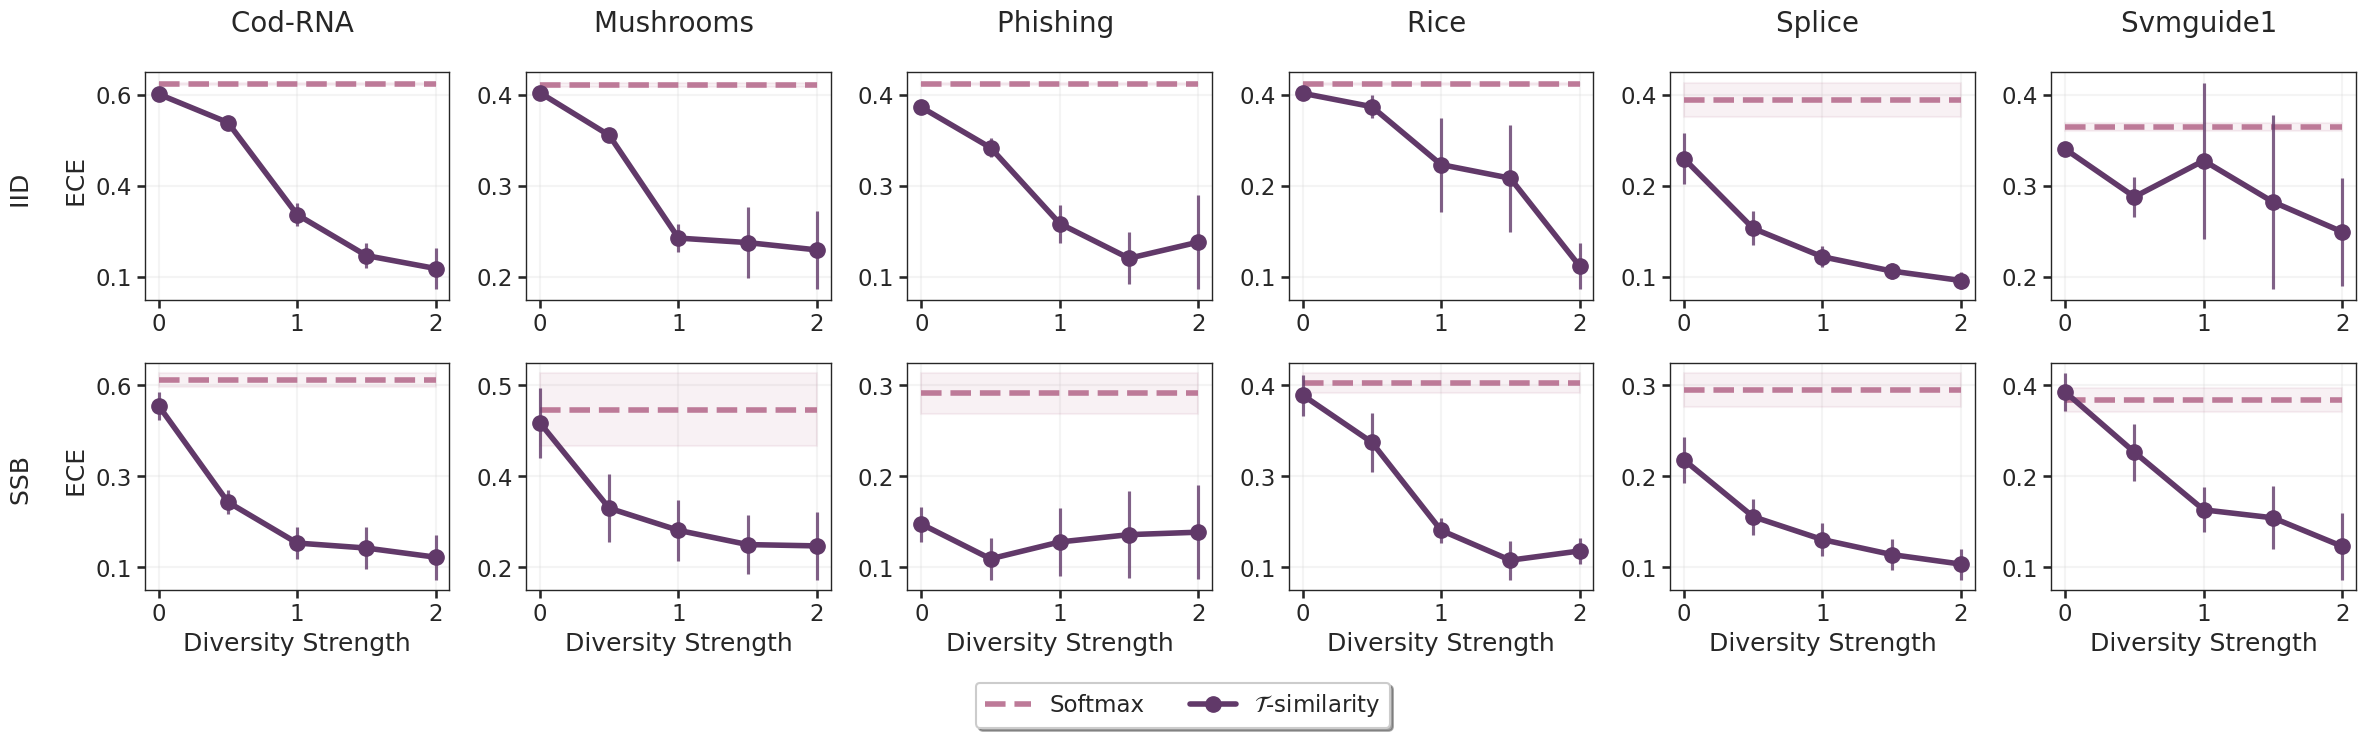

In [13]:
#### Plotting idea from https://openreview.net/pdf?id=QRBvLayFXI

save = True
dpi = 100
path = "figures"
format = "pdf"
figname = f"ECE_binary.{format}"
biases = ["balanced", "pca"]
real_name_datasets = {
    "codrna": "Cod-RNA",
    "mushrooms": "Mushrooms",
    "phishing": "Phishing",
    "rice": "Rice",
    "splice_big": "Splice",
    "svmguide1": "Svmguide1",
}
real_name_bias = {"balanced": "IID", "pca": "SSB"}
figsize = (24, 7)
lw = 4
ms = 11
fig, axes = pl.subplots(nrows=2, ncols=6, figsize=figsize)
for i, selection_bias in enumerate(biases):
    datasets = list(data.keys())
    for j, dataset_name in enumerate(datasets):
        seed_values = list(data[dataset_name].keys())
        gamma_values = data[dataset_name][seed_values[0]]["gamma_values"]
        ece_softmax = np.zeros((len(seed_values), len(gamma_values)))
        ece_similarity = np.zeros((len(seed_values), len(gamma_values)))
        for k, seed in enumerate(seed_values):
            values = data[dataset_name][seed][selection_bias]
            ece_softmax[k] = values["proj_head"]
            ece_similarity[k] = values["similarity"]
        mu_softmax, std_softmax = np.mean(ece_softmax, axis=0), np.std(
            ece_softmax, axis=0
        )
        ci_softmax = 1.96 * std_softmax / np.sqrt(len(seed_values))
        mu_similarity, std_similarity = np.mean(ece_similarity, axis=0), np.std(
            ece_similarity, axis=0
        )
        ci_similarity = 1.96 * std_similarity / np.sqrt(len(seed_values))
        ax = axes[i, j]
        N = len(gamma_values)
        ax.plot(
            np.arange(N),
            mu_softmax,
            lw=4,
            label="Softmax",
            color="#bd7a98",
            alpha=1,
            linestyle="dashed",
        )
        ax.fill_between(
            np.arange(N),
            mu_softmax - ci_softmax,
            mu_softmax + ci_softmax,
            alpha=0.1,
            color="#bd7a98",
        )
        ax.plot(
            np.arange(N),
            mu_similarity,
            label="$\mathcal{T}$-similarity",
            lw=lw,
            color="#613969",
            alpha=1,
            marker="o",
            ms=ms,
        )
        ax.errorbar(
            np.arange(N),
            mu_similarity,
            yerr=ci_similarity,
            # fmt="o",
            color="#613969",
            ms=ms,
            alpha=0.8,
        )
        ax.set_xticks(np.arange(N))
        ax.set_xticklabels(gamma_values)
        if j == 0:
            ax.set_ylabel(f"{real_name_bias[selection_bias]} \n \n ECE")
        if i == 1:
            ax.set_xlabel("Diversity Strength")
        if i == 0:
            ax.set_title(f"{real_name_datasets[dataset_name]} \n", fontsize=20)
        ax.grid(alpha=0.2)
        ax.spines["left"].set_linewidth(1)
        ax.spines["right"].set_linewidth(1)
        ax.spines["top"].set_linewidth(1)
        ax.spines["bottom"].set_linewidth(1)
        ax.tick_params(direction="out", length=6)
        ymin, ymax = ax.get_ylim()
        low = (ymax - ymin) * 0.1
        N = 3
        yticks = np.linspace(ymin + low, ymax - low, N)
        ax.set_yticks(yticks)
        ax.set_yticklabels(np.round(yticks, 1))
        ax.locator_params(axis="x", nbins=3)

# Common legend
lines_labels = [fig.axes[1].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(
    lines,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 0),
    fancybox=True,
    borderaxespad=0,
    shadow=True,
    ncol=2,
)
pl.tight_layout()
if save:
    if filename is None:
        filename = f"missing_title.{format}"
    pl.savefig(os.path.join(path, figname), format=format, bbox_inches="tight", dpi=dpi)
pl.show()